In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the CSV (betting spreads)
df = pd.read_csv("nba_data/nba_betting_spread.csv")
# Create filtered betting spreads dataset
df_betOnline = df[df['book_name'] == 'BetOnline']
df_betOnline.to_csv('nba_data/nba_betting_spread_betOnline.csv', index=False)

In [3]:
# Load the CSV (betting spreads)
df = pd.read_csv('nba_data/nba_betting_spread_betOnline.csv')
# Drop unnecessary columns
dropped_columns = ['book_name', 'book_id', 'price1', 'price2']
df_clean = df.drop(columns=dropped_columns)
# Create filtered betting spreads dataset
df_clean.to_csv('nba_data/nba_betting_spread_cleaned.csv', index=False)

In [4]:
# Load the CSV (all games)
df = pd.read_csv("nba_data/nba_games_all.csv")
# Create filtered NBA games dataset
df_filtered = df[df["season_year"] != 2006]
df_filtered.to_csv("nba_data/nba_games_all_filtered.csv", index=False)

In [5]:
# Load the CSV (filtered NBA games)
df = pd.read_csv("nba_data/nba_games_all_filtered.csv")
# Drop unnecessary columns
columns_to_drop = ["game_date", "matchup", "w", "l", "season_year", "min", "fgm", "fga", "fg_pct", "fg3m", "fg3a", "fg3_pct", "ftm", "fta", "ft_pct", "oreb", "dreb", "reb", "ast", "stl", "blk", "tov", "pf", "pts", "season"]
df_cleaned = df.drop(columns=columns_to_drop)
# Create filtered NBA games dataset
df_cleaned.to_csv("nba_data/nba_games_final.csv", index=False)

In [6]:
# Load the CSV (filtered NBA games)
games_df = pd.read_csv("nba_data/nba_games_final.csv")
# Load the CSV (filtered betting spreads)
spreads_df = pd.read_csv("nba_data/nba_betting_spread_cleaned.csv")
# Create a universal dataset by merging based on "game_id"
merged_df = games_df.merge(spreads_df[["game_id", "spread1", "spread2"]], on="game_id", how="left")
merged_df.to_csv("nba_data/factors_and_spreads.csv", index=False)

In [7]:
# Load the CSV (final dataset)
df = pd.read_csv("nba_data/factors_and_spreads.csv")
# Filter the dataset to include only games where spread1 > 0, underdogs
df_favorites = df[df["spread1"] > 0]
# Drop duplicates based on game_id, keeping only the first occurrence
df_favorites_unique = df_favorites.drop_duplicates(subset=["game_id"], keep="first")
# Save the final dataset
df_favorites_unique.to_csv("nba_data/factors_and_spreads.csv", index=False)

In [8]:
# Load the CSV (final dataset)
df = pd.read_csv("nba_data/factors_and_spreads.csv")
# Remove games where 'w_pct' is NaN
df_cleaned = df.dropna(subset=["w_pct"])
# Save the final dataset
df_cleaned.to_csv("nba_data/factors_and_spreads.csv", index=False)

In [9]:
# Load the CSV (final dataset)
df = pd.read_csv("nba_data/factors_and_spreads.csv")
# Create is_upset column: True if a team with spread1 > 0, wins
df["is_upset"] = ((df["spread1"] > 0) & (df["wl"] == "W"))
# Save the final dataset
df.to_csv("nba_data/factors_and_spreads.csv", index=False)

In [10]:
# Load the CSV (final dataset)
df = pd.read_csv("nba_data/factors_and_spreads.csv")
# Remove "Pre Season" games
df = df[df["season_type"] != "Pre Season"]
# Save the final dataset
df.to_csv("nba_data/factors_and_spreads.csv", index=False)

In [11]:
# Playoffs are viewed as the start of a new win percentage in this dataset, so this changes Playoff games' win percentage to their end-of-season record
# Load the CSV (final dataset)
df = pd.read_csv("nba_data/factors_and_spreads.csv")
# Calculate each team's regular-season win percentage
regular_season_wpct = (
    df[df["season_type"] == "Regular Season"]
    .groupby("team_id")["w_pct"]
    .last()
)
# Update Playoff games' w_pct to their team's regular-season w_pct
df.loc[df["season_type"] == "Playoffs", "w_pct"] = df["team_id"].map(regular_season_wpct)
# Save the final dataset
df.to_csv("nba_data/factors_and_spreads.csv", index=False)

In [12]:
# Load the CSV (final dataset)
df = pd.read_csv("nba_data/factors_and_spreads.csv")

# Check the overall percentage of upsets
upset_rate = df["is_upset"].mean()
print(f"Overall Upset Rate: {upset_rate:.4%}")

Overall Upset Rate: 49.1002%


In [13]:
# Load the CSV (final dataset)
df = pd.read_csv("nba_data/factors_and_spreads.csv")
# Map 't' to True, 'f' to False, and handle NaN values
df['is_home'] = df['is_home'].map({'t': True, 'f': False})
df['is_home'] = df['is_home'].astype(bool)
# Group by 'is_home' and calculate upsets and games
upset_summary_dog = df.groupby('is_home').agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Calculate proportion of upsets
upset_summary_dog['prop'] = upset_summary_dog['upsets'] / upset_summary_dog['games']
# Print the results
print(upset_summary_dog)
# Bin teams into four groups based on win percentage
df["w_pct_bin"] = pd.qcut(df["w_pct"], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])
# Create a new column that combines 'is_home' and 'w_pct_bin' called 'home_w_pct_bin'
df['home_w_pct_bin'] = df['is_home'].map({True: 'Home', False: 'Away'}) + " " + df['w_pct_bin'].astype(str)
# Group by the new 'home_w_pct_bin' column and calculate upset statistics
upset_summary = df.groupby('home_w_pct_bin').agg(
    upsets=('is_upset', 'sum'),
    games=('is_upset', 'count')
)
# Bin teams into four groups based on win percentage for additional analysis
w_pct_upset_summary = df.groupby("w_pct_bin", observed=False).agg(
    upsets=("is_upset", "sum"),
    games=("is_upset", "count")
)
# Calculate upset proportion
w_pct_upset_summary["prop"] = w_pct_upset_summary["upsets"] / w_pct_upset_summary["games"]
# Print the results
print(w_pct_upset_summary)
# Calculate upset proportion
upset_summary['prop'] = upset_summary['upsets'] / upset_summary['games']
# Print the results
print(upset_summary)

         upsets  games      prop
is_home                         
False      1325   4698  0.282035
True       3204   4526  0.707910
           upsets  games      prop
w_pct_bin                         
Low           627   2345  0.267377
Mid-Low      1024   2272  0.450704
Mid-High     1289   2308  0.558492
High         1589   2299  0.691170
                upsets  games      prop
home_w_pct_bin                         
Away High          297    705  0.421277
Away Low           315   1728  0.182292
Away Mid-High      331    986  0.335700
Away Mid-Low       382   1279  0.298671
Home High         1292   1594  0.810540
Home Low           312    617  0.505673
Home Mid-High      958   1322  0.724660
Home Mid-Low       642    993  0.646526


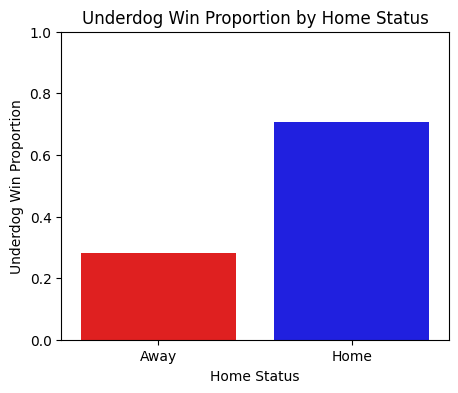

In [14]:
# Reset the index
upset_summary_dog = upset_summary_dog.reset_index()
# Create the bar plot
upset_summary_dog['home_status'] = upset_summary_dog['is_home'].map({True: 'Home', False: 'Away'})
plt.figure(figsize = (5,4))
sns.barplot(
    x='home_status',
    y='prop',
    hue='home_status',
    data=upset_summary_dog,
    palette=('red', 'blue'),
    legend=False
)
# Label the bar plot
plt.xlabel('Home Status')
plt.ylabel('Underdog Win Proportion')
plt.title("Underdog Win Proportion by Home Status")
plt.ylim(0,1)
plt.show()

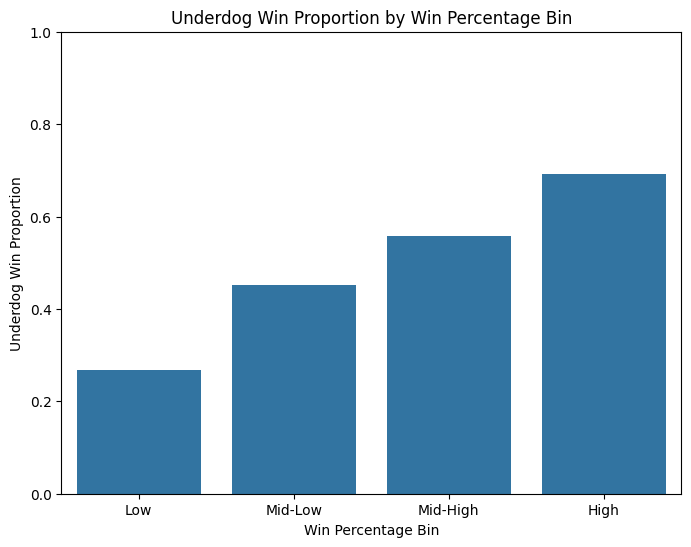

In [15]:
# Reset the index
w_pct_upset_summary = w_pct_upset_summary.reset_index()
# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x='w_pct_bin', 
    y='prop', 
    data=w_pct_upset_summary,
)
# Label the bar plot
plt.xlabel("Win Percentage Bin")
plt.ylabel("Underdog Win Proportion")
plt.title("Underdog Win Proportion by Win Percentage Bin")
plt.ylim(0, 1)
plt.show()

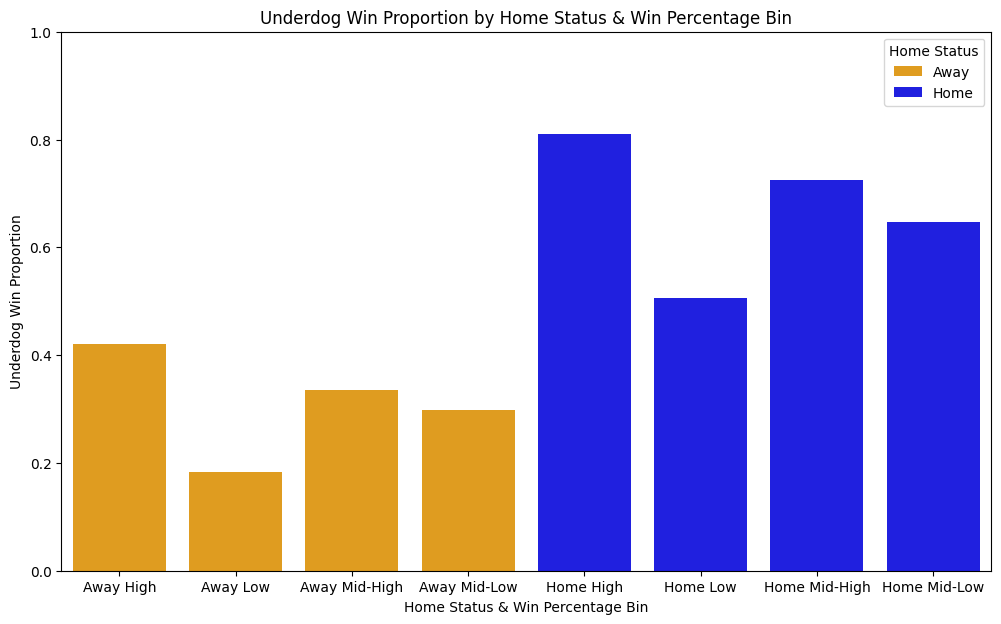

In [16]:
# Reset the index
upset_summary = upset_summary.reset_index()
# Extract "Home" or "Away" from the `home_w_pct_bin` column
upset_summary['home_status'] = upset_summary['home_w_pct_bin'].apply(lambda x: 'Home' if 'Home' in x else 'Away')
# Create the bar plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x='home_w_pct_bin', 
    y='prop', 
    hue='home_status', 
    data=upset_summary, 
    palette={'Home': 'blue', 'Away': 'orange'}
)
# Label the bar plot
plt.xlabel("Home Status & Win Percentage Bin")
plt.ylabel("Underdog Win Proportion")
plt.title("Underdog Win Proportion by Home Status & Win Percentage Bin")
plt.ylim(0, 1)
plt.legend(title='Home Status', loc='upper right')

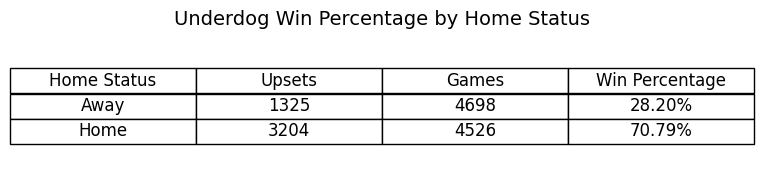

In [17]:
# Create table for Win Percentage for Home Status
data = [
    ["Away", 1325, 4698, '28.20%'],
    ["Home", 3204, 4526, '70.79%']
]
# Column headers
headers = ["Home Status", "Upsets", "Games", "Win Percentage"]
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2))
# Hide axes
ax.axis('off')
# Create the table
table = ax.table(
    cellText=data,
    colLabels=headers, 
    loc='center', 
    cellLoc='center' 
)
table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(1.2, 1.5)
plt.title("Underdog Win Percentage by Home Status", fontsize=14, pad=1)
plt.show()

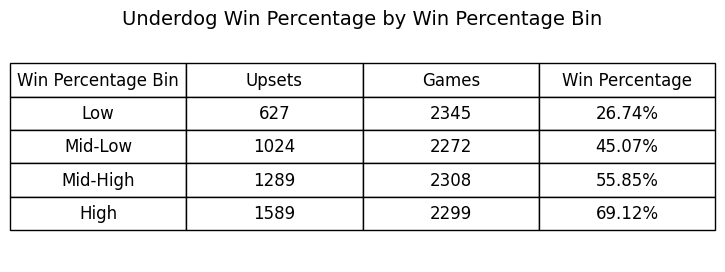

In [18]:
# Create table for Win Percentage for Win Percentage Bin 
data = [
    ["Low", 627, 2345, '26.74%'],
    ["Mid-Low", 1024, 2272, '45.07%'],
    ["Mid-High", 1289, 2308, '55.85%'],
    ["High", 1589, 2299, '69.12%'],
]
# Column headers
headers = ["Win Percentage Bin", "Upsets", "Games", "Win Percentage"]
# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 3))
# Hide axes
ax.axis('off')
# Create the table
table = ax.table(
    cellText=data, 
    colLabels=headers, 
    loc='center', 
    cellLoc='center' 
)
table.auto_set_font_size(False) 
table.set_fontsize(12)  
table.scale(1.3, 2) 
plt.title("Underdog Win Percentage by Win Percentage Bin", fontsize=14, pad=5)
plt.show()

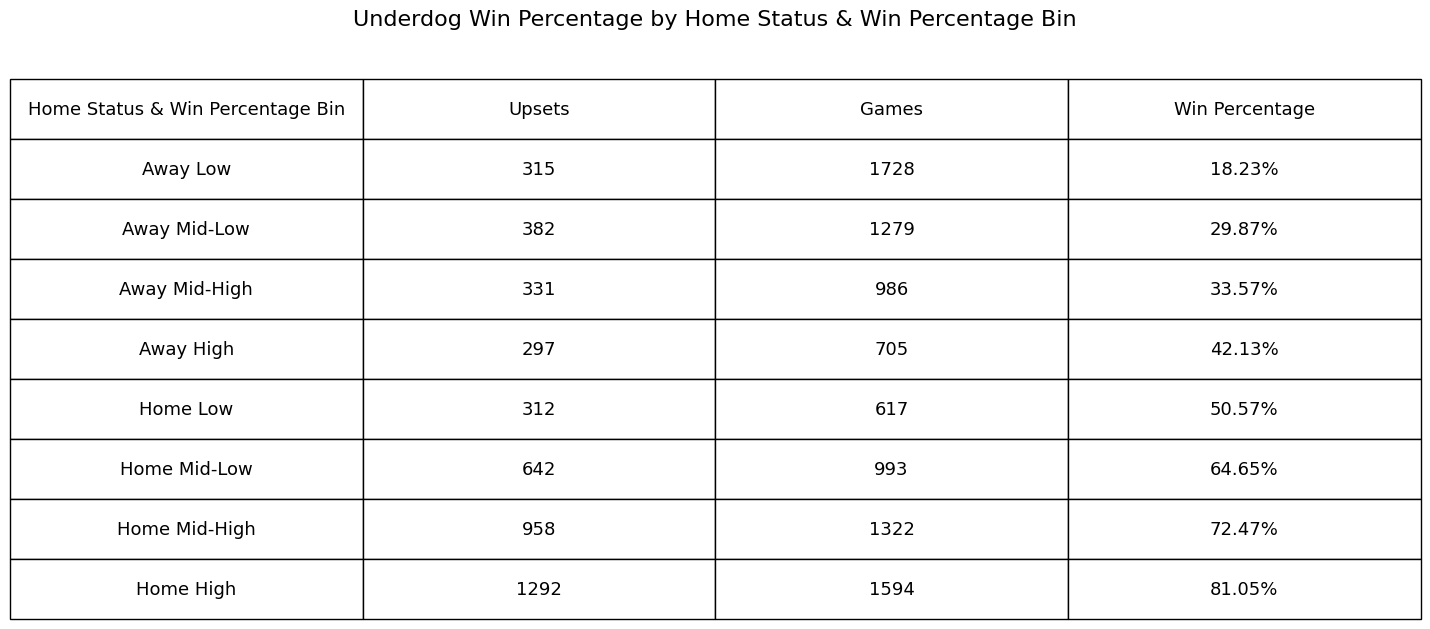

In [19]:
# Create table for Win Percentage for Home Status & Win Percentage Bin 
data = [
    ["Away Low", 315, 1728, '18.23%'],
    ["Away Mid-Low", 382, 1279, '29.87%'],
    ["Away Mid-High", 331, 986, '33.57%'],
    ["Away High", 297, 705, '42.13%'],
    ["Home Low", 312, 617, '50.57%'],
    ["Home Mid-Low", 642, 993, '64.65%'],
    ["Home Mid-High", 958, 1322, '72.47%'],
    ["Home High", 1292, 1594, '81.05%'],   
]
# Column headers
headers = ["Home Status & Win Percentage Bin", "Upsets", "Games", "Win Percentage"]
# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 3))
# Hide axes
ax.axis('off')
# Create the table
table = ax.table(
    cellText=data, 
    colLabels=headers, 
    loc='center', 
    cellLoc='center' 
)
table.auto_set_font_size(False) 
table.set_fontsize(13)  
table.scale(1.3, 3.6) 
plt.title("Underdog Win Percentage by Home Status & Win Percentage Bin", fontsize=16, pad=150)
plt.show()